In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import acquire

In [2]:
# get dataframe from acquire module
df = acquire.get_df()

In [35]:
df.head()

,unix,symbol,open,high,low,close,volum,day_of_week
date,,,,,,,,
2015-10-08 04:00:00,1444276800,BTCUSD,0.00,245.00,0.00,243.60,34.754703,Thursday
2015-10-09 04:00:00,1444363200,BTCUSD,243.60,249.97,243.60,245.51,61.587068,Friday
2015-10-10 04:00:00,1444449600,BTCUSD,245.51,246.30,244.60,246.30,30.870549,Saturday
2015-10-11 04:00:00,1444536000,BTCUSD,246.30,249.50,245.96,248.98,22.747091,Sunday
2015-10-12 04:00:00,1444622400,BTCUSD,248.98,248.98,245.75,245.75,71.047743,Monday


In [3]:
# rename columns for ease of use
df.rename(columns= {'Unix Timestamp':'unix','Date':'date','Symbol':'symbol','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace = True)

In [4]:
# change date column to datetime
df.date = pd.to_datetime(df.date)

# set the index to the date
df = df.set_index('date').sort_index()

# create day of week column for exploration use
df['day_of_week'] = df.index.day_name()

In [5]:
# how many days of each crypto are in the dataframe
df.symbol.value_counts()

BTCUSD    2359
ETHUSD    2145
LTCUSD    1255
Name: symbol, dtype: int64

<AxesSubplot:xlabel='date'>

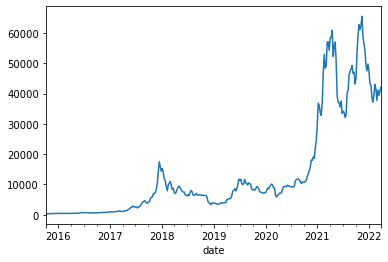

In [6]:
# check the daily mean of closing price for bitcoin
df[df.symbol == 'BTCUSD'].resample('W').close.mean().plot()

<AxesSubplot:xlabel='date'>

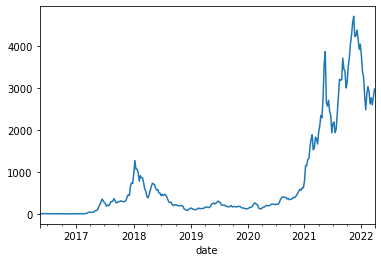

In [7]:
# repeat for etherium
df[df.symbol == 'ETHUSD'].resample('W').close.mean().plot()

<AxesSubplot:xlabel='date'>

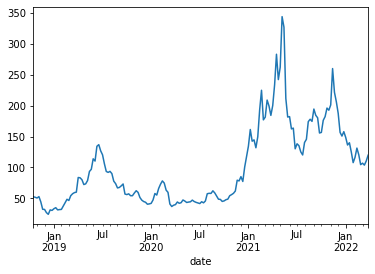

In [8]:
# repeat for lightcoin
df[df.symbol == 'LTCUSD'].resample('W').close.mean().plot()

With the massive hike in crypto in 2021, cutting out earlier dates may improve modeling

In [14]:
# create second dataframe of dates >= 2021
df2 = df[df.index >= "2021"]

In [15]:
# we should have the same amount of obserations for each cryptocurrency now
df2.symbol.value_counts()

BTCUSD    447
LTCUSD    447
ETHUSD    447
Name: symbol, dtype: int64

<AxesSubplot:xlabel='date'>

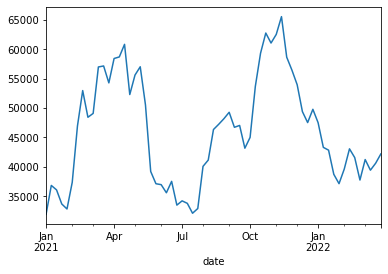

In [11]:
# double check plot 
df2[df2.symbol == 'BTCUSD'].resample('W').close.mean().plot()

It does not look like there is a seasonality and with the volatility of crypto, Cross Validation might be the best approach to splitting the data.

In [30]:
# import split
from sklearn.model_selection import TimeSeriesSplit

In [56]:
# define X and y for splitting
X = df.drop(columns = 'close')
y = df.close

In [61]:
# create the splitter
# test_size set to 60 to cover two months of data
# gap of 1 day between train/test
tscv = TimeSeriesSplit(n_splits = 5, test_size = 60, gap = 1)

In [62]:
# use the splitter
all_splits = list(tscv.split(X, y))

In [63]:
# check first split
train_0, test_0 = all_splits[0]

In [65]:
# double check split shapes
print(X.iloc[train_0].shape)
print(X.iloc[test_0].shape)

(5458, 7)
(60, 7)


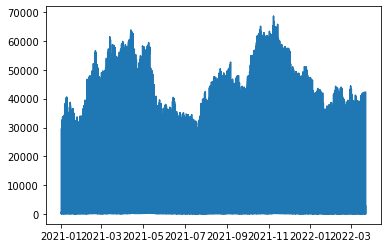

In [23]:
plt.plot(train.index, train.close)
plt.plot(test.index, test.close)